In [2]:
import pandas as pd
from basketball_reference_web_scraper import client
from basketball_reference_web_scraper.data import OutputType

## Gathering NBA Player Data

In [3]:
nba_player_stats_df = pd.DataFrame()
for year in range(2000, 2021):
    all_player_season_total = client.players_season_totals(season_end_year=year, output_type=OutputType.JSON)
    nba_player_stats_year_df = pd.read_json(all_player_season_total)
    nba_player_stats_df = pd.concat([nba_player_stats_df, nba_player_stats_year_df])
nba_player_stats_df = nba_player_stats_df.drop_duplicates(subset=['slug'])
nba_player_stats_df = nba_player_stats_df.reset_index().drop('index',axis=1)

Making sure duplicated data is removed

In [4]:
nba_player_stats_df['slug'].value_counts()

brownde03    1
oladivi01    1
labissk01    1
chrisdi01    1
johnsch04    1
            ..
gilgesh01    1
marbust01    1
hensojo01    1
mitchdo01    1
stewami01    1
Name: slug, Length: 2040, dtype: int64

## Filtering out Players who do not Fit Requirements
* The requirements include having attempted a mininmum of 750 career three point attempts and having college data accessible 
* 750 was decided as the threshold from reading this article https://fansided.com/2015/01/30/freelance-friday-small-sample-size-stop-small/

In [5]:
from sportsreference.nba.roster import Player as NBAPlayer
from sportsreference.ncaab.roster import Player as NCAAPlayer

nba_player_names = nba_player_stats_df[['name', 'slug']]
nba_college_player_df_column_names = ['name','slug','NBA_3PA', 'NBA_3P%', 'NCAA_FT%', 'NCAA_3P%', 'NCAA_FTA']
nba_ncaa_raw_player_data = []
nba_player_college_data_not_found = []

for player_index in range(len(nba_player_names)):
    nba_player_name = nba_player_names['name'].loc[player_index]
    nba_player_id = nba_player_names['slug'].loc[player_index]
    nba_player = NBAPlayer(nba_player_id)
    if (nba_player.three_point_attempts > 750):
        try: 
            if "." in nba_player_name:
                nba_player_name = nba_player_name.split('.')
                nba_player_name = "".join(nba_player_name)
            ncaa_player_id = nba_player_name.lower().split()
            ncaa_player_id = '-'.join(ncaa_player_id) + '-1'
            ncaa_player = NCAAPlayer(ncaa_player_id) 
            
            #Each index matches the nba_college_player_df_column_names
            nba_ncaa_raw_player_data.append([
                nba_player_name,
                nba_player_id, 
                nba_player.three_point_attempts,
                nba_player.three_point_percentage,
                ncaa_player.free_throw_percentage,
                ncaa_player.three_point_percentage,
                ncaa_player.free_throw_attempts

            ])
            
        except TypeError as e:
            print(nba_player_names['name'].loc[player_index], ' not found! ', ncaa_player_id)
            nba_player_college_data_not_found.append([
                nba_player_names['name'].loc[player_index],
                nba_player_id, 
                player_index
            ])

Darrell Armstrong  not found!  darrell-armstrong-1
Kobe Bryant  not found!  kobe-bryant-1
Mario Elie  not found!  mario-elie-1
Devean George  not found!  devean-george-1
Al Harrington  not found!  al-harrington-1
Toni Kukoč  not found!  toni-kukoč-1
Rashard Lewis  not found!  rashard-lewis-1
Tracy McGrady  not found!  tracy-mcgrady-1
Dirk Nowitzki  not found!  dirk-nowitzki-1
Scottie Pippen  not found!  scottie-pippen-1
Terry Porter  not found!  terry-porter-1
Peja Stojaković  not found!  peja-stojaković-1
Metta World Peace  not found!  metta-world-peace-1
Stephen Jackson  not found!  stephen-jackson-1
DeShawn Stevenson  not found!  deshawn-stevenson-1
Hedo Türkoğlu  not found!  hedo-türkoğlu-1
Andrei Kirilenko  not found!  andrei-kirilenko-1
Vladimir Radmanović  not found!  vladimir-radmanović-1
Manu Ginóbili  not found!  manu-ginóbili-1
Gordan Giriček  not found!  gordan-giriček-1
Marko Jarić  not found!  marko-jarić-1
Ronald Murray  not found!  ronald-murray-1
Boštjan Nachbar  not f

In [6]:
nba_ncaa_data_df = pd.DataFrame(nba_ncaa_raw_player_data, columns =nba_college_player_df_column_names)
nba_ncaa_not_found_df = pd.DataFrame(nba_player_college_data_not_found, columns=['name','slug', 'player_df_index'])

In [7]:
nba_ncaa_data_df.sort_values(by=['NCAA_FT%'])

,name,slug,NBA_3PA,NBA_3P%,NCAA_FT%,NCAA_3P%,NCAA_FTA
374,Joe Harris,harrijo01,1459,0.426,0.000,0.375,4
371,Aaron Gordon,gordoaa01,1383,0.319,0.422,0.356,180
214,Josh Smith,smithjo03,1578,0.285,0.500,NaN,2
205,Trevor Ariza,arizatr01,4362,0.352,0.504,0.237,113
305,Wesley Johnson,johnswe01,1823,0.337,0.508,NaN,61
...,...,...,...,...,...,...,...
297,Luke Babbitt,babbilu01,979,0.402,0.893,0.421,393
315,Kyrie Irving,irvinky01,2870,0.390,0.901,0.462,71
240,JJ Redick,redicjj01,4526,0.416,0.912,0.406,726
239,Steve Novak,novakst01,1337,0.430,0.931,0.461,261


We have an outlier in Joe Harris and this is from a bug in error collection so we'll drop that row 

In [8]:
nba_ncaa_data_df = nba_ncaa_data_df.drop(374)
nba_ncaa_data_df = nba_ncaa_data_df.dropna()
nba_ncaa_data_df['NBA_3P%'].corr(nba_ncaa_data_df['NCAA_FT%'])

0.39713533519150995

A moderate to low correlation! Let's graph out our data and see what it looks like.

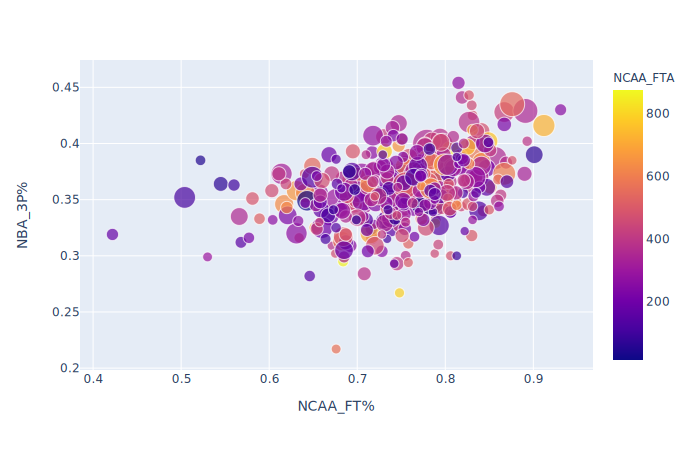

In [17]:
import plotly.express as px
fig = px.scatter(nba_ncaa_data_df, x="NCAA_FT%", y="NBA_3P%", size="NBA_3PA", color="NCAA_FTA", hover_data=["name"])
fig.show("svg")

Let's find out how this metric compares for great three point shooters. We'll filter by shooters who shoot three pointers at or above 40%.

In [13]:
above_40_percent_df = nba_ncaa_data_df[nba_ncaa_data_df['NBA_3P%'] > 0.4]
above_40_percent_df['NCAA_FT%'].corr(above_40_percent_df['NBA_3P%'])

0.3535460742223576

Not much better, how about sorting for top 50 FTA in the NCAA?

In [14]:
top_50_NCAA_FTA_df = nba_ncaa_data_df.sort_values(by=['NCAA_FTA'], ascending=False)[0:50]
top_50_NCAA_FTA_df['NCAA_FT%'].corr(top_50_NCAA_FTA_df['NBA_3P%'])

0.5051095182727158

A better correlation. How about we visualize the data

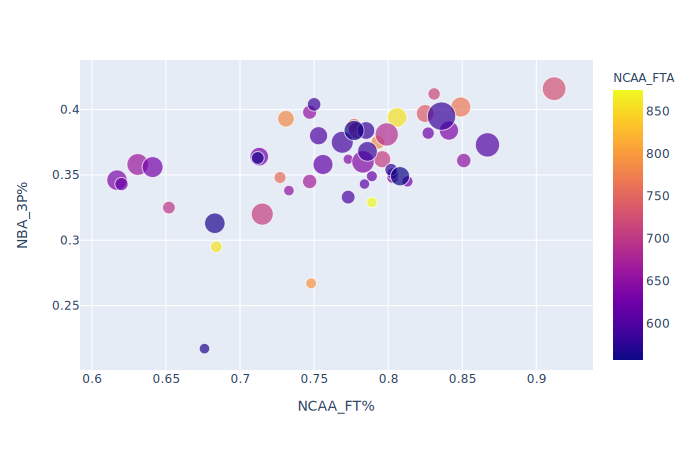

In [16]:
fig = px.scatter(nba_ncaa_data_df.sort_values(by=['NCAA_FTA'], ascending=False)[0:50], x="NCAA_FT%", y="NBA_3P%", size="NBA_3PA", color="NCAA_FTA", hover_data=["name"])
fig.show("svg")

In [112]:
nba_ncaa_data_df.to_csv('data/nba_ncaa_data_df_2000_2020.csv', index=False)
nba_ncaa_not_found_df.to_csv('data/nba_ncaa_not_found_df_2000_2020.csv', index=False)